## Problem

Using Network Analysis to solve the Chinese Postman Problem.

## About

The Chinese Postman Problem (CPP), also referred to as the Route Inspection or Arc Routing problem, is quite similar to the Travelling Salesman Problem which amounts to finding the shortest route (say, roads) that connects a set of nodes (say, cities).
The objective of the CPP is to find the shortest path that covers all the links (roads) on a graph at least once. If this is possible without doubling back on the same road twice, great; That's the ideal scenario and the problem is quite simple. However, if some roads must be traversed more than once, you need some math to find the shortest route that hits every road at least once with the lowest total mileage.

The solution to this CPP problem will be a Eulerian tour: a graph where a cycle that passes through every edge exactly once can be made from a starting node back to itself (without backtracking).

## Data

The edge list is a simple data structure that we'll use to create the graph. Each row represents a single edge of the graph with some edge attributes.

1.    node1 & node2: names of the nodes connected.
2.    trail: edge attribute indicating the abbreviated name of the trail for each edge. For example: rs = red square
3.    distance: edge attribute indicating trail length in miles.
4.    color: trail color used for plotting.
5.    estimate: edge attribute indicating whether the edge distance is estimated from eyeballing the trailmap (1=yes, 0=no) as some distances are not provided. This is solely for reference; it is not used for analysis.


In [1]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
edgelist = pd.read_csv('../Data/edgelist_sleeping_giant.csv')


In [3]:
edgelist.head(10)

,node1,node2,trail,distance,color,estimate
0,rs_end_north,v_rs,rs,0.30,red,0
1,v_rs,b_rs,rs,0.21,red,0
2,b_rs,g_rs,rs,0.11,red,0
3,g_rs,w_rs,rs,0.18,red,0
4,w_rs,o_rs,rs,0.21,red,0
5,o_rs,y_rs,rs,0.12,red,0
6,y_rs,rs_end_south,rs,0.39,red,0
7,rc_end_north,v_rc,rc,0.70,red,0
8,v_rc,b_rc,rc,0.04,red,0
9,b_rc,g_rc,rc,0.15,red,0


In [4]:
edgelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 6 columns):
node1       123 non-null object
node2       123 non-null object
trail       123 non-null object
distance    123 non-null float64
color       123 non-null object
estimate    123 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.8+ KB


Node lists are usually optional in networkx and other graph libraries when edge lists are provided because the node names are provided in the edge list's first two columns. However, in this case, there are some node attributes that we'd like to add: X, Y coordinates of the nodes (trail intersections) so that we can plot our graph with the same layout as the trail map. 

The nodelist contains :

1.    id: name of the node corresponding to node1 and node2 in the edge list.
2.    X: horizontal position/coordinate of the node relative to the topleft.
3.    Y vertical position/coordinate of the node relative to the topleft.


In [5]:
nodelist = pd.read_csv('../Data/nodelist_sleeping_giant.csv')

In [6]:
nodelist.head(10)

,id,X,Y
0,b_bv,1486,732
1,b_bw,716,1357
2,b_end_east,3164,1111
3,b_end_west,141,1938
4,b_g,1725,771
5,b_gy2,2000,983
6,b_o,2039,1012
7,b_rc,1311,979
8,b_rd,268,1744
9,b_rd_dupe,268,1744


In [7]:
nodelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
id    77 non-null object
X     77 non-null int64
Y     77 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.9+ KB


## Create Graph

Now you use the edge list and the node list to create a graph object in networkx.

In [8]:
# Create empty graph
g = nx.Graph()

In [9]:
# Add edges and edge attributes
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [10]:
# Edge list example
print(elrow[0]) # node1
print(elrow[1]) # node2
print(elrow[2:].to_dict()) # edge attribute dict

o_gy2
y_gy2
{'color': 'yellowgreen', 'trail': 'gy2', 'estimate': 0, 'distance': 0.12}


In [11]:
# Add node attributes
for i, nlrow in nodelist.iterrows():
    g.node[nlrow['id']].update(nlrow[1:].to_dict())

In [12]:
# Node list example
print(nlrow)

id    y_rt
X      977
Y     1666
Name: 76, dtype: object


## Inspect Graph

##### Edges

Your graph edges are represented by a list of tuples of length 3. The first two elements are the node names linked by the edge. The third is the dictionary of edge attributes.

In [13]:
# Preview first 5 edges
list(g.edges(data=True))[0:5]

[('b_rd_dupe',
  'rd_end_south_dupe',
  {'attr_dict': {'color': 'blue',
    'distance': 0.16,
    'estimate': 0,
    'trail': 'b'}}),
 ('b_rd_dupe',
  'b_rd',
  {'attr_dict': {'color': 'black',
    'distance': 0.0,
    'estimate': 0,
    'trail': 'hack'}}),
 ('nature_end_west',
  'o_y_tt_end_west',
  {'attr_dict': {'color': 'black',
    'distance': 0.16,
    'estimate': 0,
    'trail': 'tt'}}),
 ('nature_end_west',
  'y_rh',
  {'attr_dict': {'color': 'forestgreen',
    'distance': 0.11,
    'estimate': 0,
    'trail': 'nature'}}),
 ('nature_end_west',
  'rh_end_tt_4',
  {'attr_dict': {'color': 'black',
    'distance': 0.2,
    'estimate': 0,
    'trail': 'tt'}})]

###### Nodes

Similarly, your nodes are represented by a list of tuples of length 2. The first element is the node ID, followed by the dictionary of node attributes.



In [14]:
# Preview first 5 nodes
list(g.nodes(data=True))[0:5]

[('b_rd_dupe', {'X': 268, 'Y': 1744}),
 ('nature_end_west', {'X': 600, 'Y': 1861}),
 ('y_gy1', {'X': 1258, 'Y': 1558}),
 ('g_w', {'X': 700, 'Y': 1582}),
 ('v_bv', {'X': 1425, 'Y': 691})]

In [15]:
print('number of edges: {}'.format(g.number_of_edges()))
print('number of nodes: {}'.format(g.number_of_nodes()))

number of edges: 123
number of nodes: 77


## Visualization

#### Positions

First you need to manipulate the node positions from the graph into a dictionary. This will allow you to recreate the graph using the same layout as the actual trail map. Y is negated to transform the Y-axis origin from the topleft to the bottomleft.

In [16]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])

{'b_rc': (1311, -979),
 'b_rd_dupe': (268, -1744),
 'g_w': (700, -1582),
 'v_bv': (1425, -691),
 'y_rs': (1805, -1246)}

#### Colors

Now you manipulate the edge colors from the graph into a simple list so that you can visualize the trails by their color.

In [17]:
# Define data structure (list) of edge colors for plotting
edge_colors = [e[2]['attr_dict']['color'] for e in g.edges(data=True)]

# Preview first 5
edge_colors[0:5]

['blue', 'black', 'black', 'forestgreen', 'black']

#### Plot

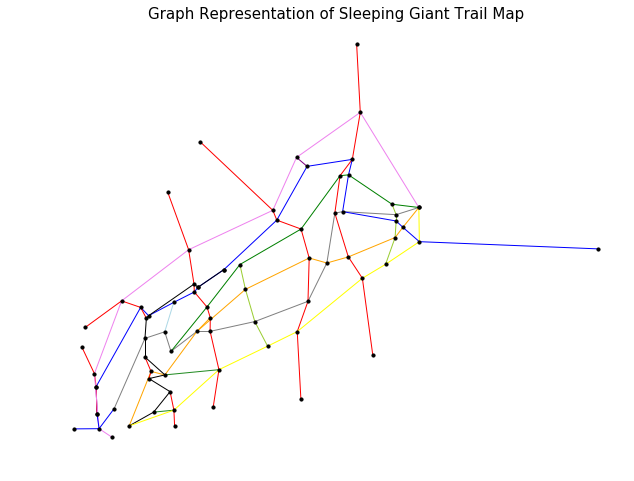

In [18]:
plt.figure(figsize=(8, 6))
nx.draw(g, pos=node_positions, edge_color=edge_colors, node_size=10, node_color='black')
plt.title('Graph Representation of Sleeping Giant Trail Map', size=15)
plt.show()

## Chinese Postman Problem Solution

Solving the Chinese Postman Problem is quite simple conceptually:

1.    Find all nodes with odd degree (very easy).
    (Find all trail intersections where the number of trails touching that intersection is an odd number)

2.    Add edges to the graph such that all nodes of odd degree are made even. These added edges must be duplicates from the original graph (we'll assume no bushwhacking for this problem). The set of edges added should sum to the minimum distance possible (hard...np-hard to be precise).
    (In simpler terms, minimize the amount of double backing on a route that hits every trail)

3.    Given a starting point, find the Eulerian tour over the augmented dataset (moderately easy).
    (Once we know which trails we'll be double backing on, actually calculate the route from beginning to end)


#### Find Nodes of Odd Degree

This is a pretty straightforward counting computation. You see that 36 of the 76 nodes have odd degree. These are mostly the dead-end trails (degree 1) and intersections of 3 trails. There are a handful of degree 5 nodes.

In [19]:
# Calculate list of nodes with odd degree
nodes_odd_degree = [v for v, d in g.degree() if d % 2 == 1]

# Preview
nodes_odd_degree[0:5]

['nature_end_west', 'y_gy1', 'g_w', 'v_bv', 'b_tt_3']

In [20]:
# Counts
print('Number of nodes of odd degree: {}'.format(len(nodes_odd_degree)))
print('Number of total nodes: {}'.format(len(g.nodes())))

Number of nodes of odd degree: 36
Number of total nodes: 77


#### Find Min Distance Pairs

This is really the meat of the problem. You'll break it down into 5 parts:

1.    Compute all possible pairs of odd degree nodes.
2.    Compute the shortest path between each node pair calculated in 1.
3.    Create a complete graph connecting every node pair in 1. with shortest path distance attributes calculated in 2.
4.    Compute a minimum weight matching of the graph calculated in 3.
    (This boils down to determining how to pair the odd nodes such that the sum of the distance between the pairs is as small as possible).
5.    Augment the original graph with the shortest paths between the node pairs calculated in 4.


###### Compute Node Pairs

In [21]:
# Compute all pairs of odd nodes. in a list of tuples
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

# Preview pairs of odd degree nodes
odd_node_pairs[0:10]

[('nature_end_west', 'y_gy1'),
 ('nature_end_west', 'g_w'),
 ('nature_end_west', 'v_bv'),
 ('nature_end_west', 'b_tt_3'),
 ('nature_end_west', 'o_y_tt_end_west'),
 ('nature_end_west', 'b_end_west'),
 ('nature_end_west', 'rs_end_north'),
 ('nature_end_west', 'rd_end_north'),
 ('nature_end_west', 'g_gy1'),
 ('nature_end_west', 'rt_end_south')]

In [22]:
# Counts
print('Number of pairs: {}'.format(len(odd_node_pairs)))

Number of pairs: 630


###### Compute Shortest Paths between Node Pairs

In [23]:
#Dijkstra's algorithm to get shortest paths
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [24]:
# Compute shortest paths.  Return a dictionary with node pairs keys and a single value equal to shortest path distance.
odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'distance')

# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])

{('b_tt_3', 'y_rh'): 7,
 ('g_w', 'rd_end_north'): 6,
 ('g_w', 'rh_end_tt_4'): 4,
 ('rd_end_north', 'rh_end_north'): 3,
 ('rd_end_north', 'y_rh'): 8,
 ('rh_end_south', 'y_rt'): 2,
 ('rh_end_tt_2', 'rh_end_south'): 4,
 ('rs_end_south', 'y_gy2'): 2,
 ('v_bv', 'rh_end_tt_2'): 7,
 ('w_bw', 'y_rh'): 5}

###### Create Complete Graph

In [25]:
#Creating complete graph
def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters: 
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        g.add_edge(k[0], k[1], attr_dict={'distance': v, 'weight': wt_i})
    return g

In [26]:
# Generate the complete graph
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))

Number of nodes: 36
Number of edges: 630


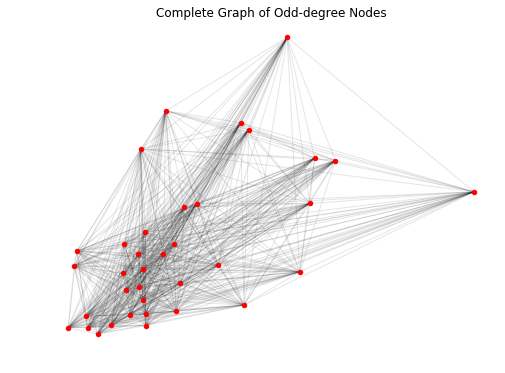

In [27]:
# Plot the complete graph of odd-degree nodes
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.1)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()

######  Compute Minimum Weight Matching

In [28]:
# Compute min weight matching.
# Note: max_weight_matching uses the 'weight' attribute by default as the attribute to maximize.
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)

print('Number of edges in matching: {}'.format(len(odd_matching_dupes)))

Number of edges in matching: 18


In [29]:
# Preview of matching with dupes
odd_matching_dupes

{('b_bw', 'rh_end_north'),
 ('b_end_west', 'rc_end_south'),
 ('b_tt_3', 'o_tt'),
 ('g_gy1', 'nature_end_west'),
 ('g_gy2', 'rs_end_south'),
 ('g_w', 'o_rt'),
 ('o_w_1', 'y_gy1'),
 ('o_y_tt_end_west', 'y_gy2'),
 ('rd_end_north', 'b_bv'),
 ('rh_end_tt_1', 'w_bw'),
 ('rh_end_tt_2', 'rc_end_north'),
 ('rh_end_tt_3', 'rd_end_south'),
 ('rh_end_tt_4', 'rs_end_north'),
 ('rt_end_north', 'b_end_east'),
 ('rt_end_south', 'b_v'),
 ('v_end_east', 'rh_end_south'),
 ('v_end_west', 'y_rh'),
 ('y_rt', 'v_bv')}

In [30]:
# Convert matching to list of deduped tuples
odd_matching = list(pd.unique([tuple(sorted([k, v])) for k, v in dict(odd_matching_dupes).items()]))

# Counts
print('Number of edges in matching (deduped): {}'.format(len(odd_matching)))

Number of edges in matching (deduped): 18


In [31]:
# Preview of deduped matching
odd_matching

[('b_end_east', 'rt_end_north'),
 ('b_end_west', 'rc_end_south'),
 ('g_gy1', 'nature_end_west'),
 ('o_y_tt_end_west', 'y_gy2'),
 ('o_w_1', 'y_gy1'),
 ('g_gy2', 'rs_end_south'),
 ('b_bw', 'rh_end_north'),
 ('g_w', 'o_rt'),
 ('rh_end_south', 'v_end_east'),
 ('b_bv', 'rd_end_north'),
 ('b_v', 'rt_end_south'),
 ('v_bv', 'y_rt'),
 ('rh_end_tt_1', 'w_bw'),
 ('b_tt_3', 'o_tt'),
 ('rd_end_south', 'rh_end_tt_3'),
 ('rc_end_north', 'rh_end_tt_2'),
 ('v_end_west', 'y_rh'),
 ('rh_end_tt_4', 'rs_end_north')]

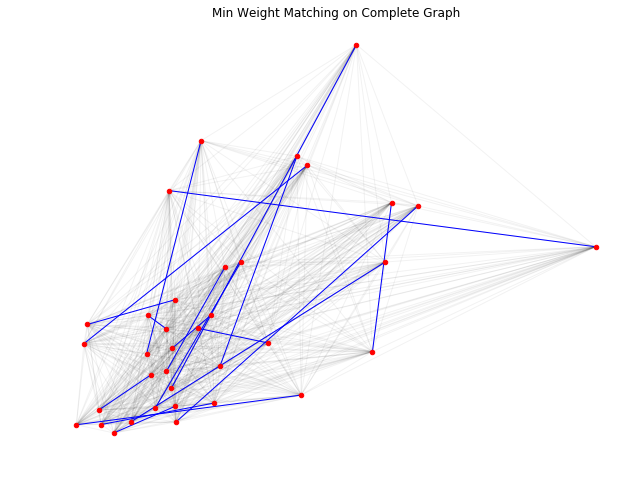

In [32]:
plt.figure(figsize=(8, 6))

# Plot the complete graph of odd-degree nodes
nx.draw(g_odd_complete, pos=node_positions, node_size=20, alpha=0.05)

# Create a new graph to overlay on g_odd_complete with just the edges from the min weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on Complete Graph')
plt.show()

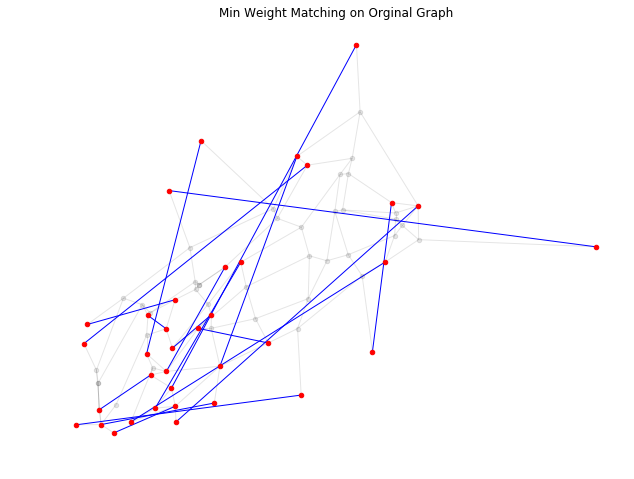

In [33]:
plt.figure(figsize=(8, 6))

# Plot the original trail map graph
nx.draw(g, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()

###### Augment the Original Graph

In [34]:
def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """

    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0], 
                           pair[1], 
                           attr_dict={'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]),
                                      'trail': 'augmented'}
                          )
    return graph_aug

In [35]:
# Create augmented graph: add the min weight matching edges to g
g_aug = add_augmenting_path_to_graph(g, odd_matching)

# Counts
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of edges in augmented graph: {}'.format(len(g_aug.edges())))

Number of edges in original graph: 123
Number of edges in augmented graph: 141


In [36]:
pd.value_counts(g_aug.degree())

(bstub_w, 2)            1
(b_rc, 4)               1
(b_tt_3, 4)             1
(v_end_east, 2)         1
(y_rs, 4)               1
(v_rc, 4)               1
(rc_end_north, 2)       1
(b_tt_3_dupe, 2)        1
(b_end_west, 2)         1
(v_rs, 4)               1
(nature_end_west, 4)    1
(b_o, 4)                1
(w_rc, 4)               1
(o_rs, 4)               1
(b_v, 6)                1
(o_rc, 4)               1
(rh_end_tt_4, 4)        1
(g_rc, 4)               1
(b_end_east, 2)         1
(b_rs, 4)               1
(o_y_tt_end_west, 4)    1
(b_tt_2_dupe, 2)        1
(rs_end_south, 2)       1
(b_bv, 4)               1
(b_w, 4)                1
(v_bv, 4)               1
(tt_rt, 4)              1
(y_rh, 6)               1
(b_tt_2, 4)             1
(b_rh, 4)               1
                       ..
(v_end_west, 2)         1
(rh_end_south, 2)       1
(g_w, 4)                1
(rc_end_south, 2)       1
(rh_end_tt_3, 4)        1
(rd_end_south, 4)       1
(o_tt, 6)               1
(b_g, 4)    

#### Compute Eulerian Circuit

Now that you have a graph with even degree the hard optimization work is over. As Euler famously postulated in 1736 with the Seven Bridges of Königsberg problem, there exists a path which visits each edge exactly once if all nodes have even degree.
There are many Eulerian circuits with the same distance that can be constructed. You can get 90% of the way there with the NetworkX eulerian_circuit function.

###### Naive Circuit

In [37]:
naive_euler_circuit = list(nx.eulerian_circuit(g_aug, source='b_end_east'))

In [38]:
print('Length of eulerian circuit: {}'.format(len(naive_euler_circuit)))

Length of eulerian circuit: 141


In [39]:
# Preview naive Euler circuit
naive_euler_circuit[0:10]

[('b_end_east', 'b_y'),
 ('b_y', 'b_o'),
 ('b_o', 'o_gy2'),
 ('o_gy2', 'y_gy2'),
 ('y_gy2', 'o_y_tt_end_west'),
 ('o_y_tt_end_west', 'nature_end_west'),
 ('nature_end_west', 'rh_end_tt_4'),
 ('rh_end_tt_4', 'y_rh'),
 ('y_rh', 'v_end_west'),
 ('v_end_west', 'b_v')]

###### Correct Circuit

In [40]:
def create_eulerian_circuit(graph_augmented, graph_original, starting_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=starting_node))

    for edge in naive_circuit:
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])    
        
        if edge_data[0]['attr_dict']['trail'] != 'augmented':
            # If `edge` exists in original graph, grab the edge attributes and add to eulerian circuit.
            edge_att = graph_original[edge[0]][edge[1]]
            euler_circuit.append((edge[0], edge[1], edge_att)) 
        else: 
            aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight='distance')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))

            print('Filling in edges for augmented edge: {}'.format(edge))
            print('Augmenting path: {}'.format(' => '.join(aug_path)))
            print('Augmenting path pairs: {}\n'.format(aug_path_pairs))

            # If `edge` does not exist in original graph, find the shortest path between its nodes and 
            #  add the edge attributes for each link in the shortest path.
            for edge_aug in aug_path_pairs:
                edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))

    return euler_circuit

In [41]:
# Create the Eulerian circuit
euler_circuit = create_eulerian_circuit(g_aug, g, 'b_end_east')

Filling in edges for augmented edge: ('y_gy2', 'o_y_tt_end_west')
Augmenting path: y_gy2 => y_rs => y_rc => y_gy1 => y_rt => y_rh => o_y_tt_end_west
Augmenting path pairs: [('y_gy2', 'y_rs'), ('y_rs', 'y_rc'), ('y_rc', 'y_gy1'), ('y_gy1', 'y_rt'), ('y_rt', 'y_rh'), ('y_rh', 'o_y_tt_end_west')]

Filling in edges for augmented edge: ('y_rh', 'v_end_west')
Augmenting path: y_rh => y_rt => o_tt => rh_end_tt_2 => w_tt => bstub_w => b_v => v_end_west
Augmenting path pairs: [('y_rh', 'y_rt'), ('y_rt', 'o_tt'), ('o_tt', 'rh_end_tt_2'), ('rh_end_tt_2', 'w_tt'), ('w_tt', 'bstub_w'), ('bstub_w', 'b_v'), ('b_v', 'v_end_west')]

Filling in edges for augmented edge: ('b_v', 'rt_end_south')
Augmenting path: b_v => bstub_w => w_tt => rh_end_tt_2 => o_tt => y_rt => rt_end_south
Augmenting path pairs: [('b_v', 'bstub_w'), ('bstub_w', 'w_tt'), ('w_tt', 'rh_end_tt_2'), ('rh_end_tt_2', 'o_tt'), ('o_tt', 'y_rt'), ('y_rt', 'rt_end_south')]

Filling in edges for augmented edge: ('y_rt', 'v_bv')
Augmenting pat

In [42]:
print('Length of Eulerian circuit: {}'.format(len(euler_circuit)))

Length of Eulerian circuit: 237


## CPP Solution

In [43]:
# Preview first 20 directions of CPP solution
for i, edge in enumerate(euler_circuit[0:20]):
    print(i, edge)

(0, ('b_end_east', 'b_y', {'attr_dict': {'color': 'blue', 'trail': 'b', 'estimate': 0, 'distance': 1.32}}))
(1, ('b_y', 'b_o', {'attr_dict': {'color': 'blue', 'trail': 'b', 'estimate': 0, 'distance': 0.08}}))
(2, ('b_o', 'o_gy2', {'attr_dict': {'color': 'orange', 'trail': 'o', 'estimate': 0, 'distance': 0.06}}))
(3, ('o_gy2', 'y_gy2', {'attr_dict': {'color': 'yellowgreen', 'trail': 'gy2', 'estimate': 0, 'distance': 0.12}}))
(4, ('y_gy2', 'y_rs', {'attr_dict': {'color': 'yellow', 'trail': 'y', 'estimate': 0, 'distance': 0.16}}))
(5, ('y_rs', 'y_rc', {'attr_dict': {'color': 'yellow', 'trail': 'y', 'estimate': 0, 'distance': 0.53}}))
(6, ('y_rc', 'y_gy1', {'attr_dict': {'color': 'yellow', 'trail': 'y', 'estimate': 0, 'distance': 0.18}}))
(7, ('y_gy1', 'y_rt', {'attr_dict': {'color': 'yellow', 'trail': 'y', 'estimate': 0, 'distance': 0.31}}))
(8, ('y_rt', 'y_rh', {'attr_dict': {'color': 'yellow', 'trail': 'y', 'estimate': 0, 'distance': 0.32}}))
(9, ('y_rh', 'o_y_tt_end_west', {'attr_dict'

You can tell pretty quickly that the algorithm is not very loyal to any particular trail, jumping from one to the next pretty quickly. An extension of this approach could get fancy and build in some notion of trail loyalty into the objective function to make actually running this route more manageable.

In [44]:
# Computing some stats
total_mileage_of_circuit = sum([edge[2]['attr_dict']['distance'] for edge in euler_circuit])
total_mileage_on_orig_trail_map = sum(nx.get_edge_attributes(g, 'distance').values())
_vcn = pd.value_counts(pd.value_counts([(e[0]) for e in euler_circuit]), sort=False)
node_visits = pd.DataFrame({'n_visits': _vcn.index, 'n_nodes': _vcn.values})
_vce = pd.value_counts(pd.value_counts([sorted(e)[0] + sorted(e)[1] for e in nx.MultiDiGraph(euler_circuit).edges()]))
edge_visits = pd.DataFrame({'n_visits': _vce.index, 'n_edges': _vce.values})

# Printing stats
print('Mileage of circuit: {0:.2f}'.format(total_mileage_of_circuit))
print('Mileage on original trail map: {0:.2f}'.format(total_mileage_on_orig_trail_map))
print('Mileage retracing edges: {0:.2f}'.format(total_mileage_of_circuit-total_mileage_on_orig_trail_map))
if total_mileage_on_orig_trail_map != 0:
    print('Percent of mileage retraced: {0:.2f}%\n'.format((1-total_mileage_of_circuit/total_mileage_on_orig_trail_map)*-100))
else:
    print('Percent of mileage retraced: {0:.2f}%\n'.format(0))
print('Number of edges in circuit: {}'.format(len(euler_circuit)))
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of nodes in original graph: {}\n'.format(len(g.nodes())))

print('Number of edges traversed more than once: {}\n'.format(len(euler_circuit)-len(g.edges())))  

print('Number of times visiting each node:')
print(node_visits.to_string(index=False))

print('\nNumber of times visiting each edge:')
print(edge_visits.to_string(index=False))

Mileage of circuit: 52.19
Mileage on original trail map: 0.00
Mileage retracing edges: 52.19
Percent of mileage retraced: 0.00%

Number of edges in circuit: 237
Number of edges in original graph: 123
Number of nodes in original graph: 77

Number of edges traversed more than once: 114

Number of times visiting each node:
n_nodes  n_visits
     17         1
     21         2
     14         3
      8         4
      6         5
      6         6
      3         7
      1         8
      1         9

Number of times visiting each edge:
n_edges  n_visits
     56         1
     42         2
     10         3
      9         4
      5         5
      1         6


## Visualize CPP Solution

First step is to convert the list of edges to walk in the Euler circuit into an edge list with plot-friendly attributes.

create_cpp_edgelist Creates an edge list with some additional attributes that you'll use for plotting:

    sequence: records a sequence of when we walk each edge.
    visits: is simply the number of times we walk a particular edge.


In [45]:
def create_cpp_edgelist(euler_circuit):
    """
    Create the edgelist without parallel edge for the visualization
    Combine duplicate edges and keep track of their sequence and # of walks
    Parameters:
        euler_circuit: list[tuple] from create_eulerian_circuit
    """
    cpp_edgelist = {}

    for i, e in enumerate(euler_circuit):
        edge = frozenset([e[0], e[1]])

        if edge in cpp_edgelist:
            cpp_edgelist[edge][2]['sequence'] += ', ' + str(i)
            cpp_edgelist[edge][2]['visits'] += 1

        else:
            cpp_edgelist[edge] = e
            cpp_edgelist[edge][2]['sequence'] = str(i)
            cpp_edgelist[edge][2]['visits'] = 1

    return list(cpp_edgelist.values())

In [46]:
cpp_edgelist = create_cpp_edgelist(euler_circuit)
print('Number of edges in CPP edge list: {}'.format(len(cpp_edgelist)))

Number of edges in CPP edge list: 123


In [47]:
# Preview CPP plot-friendly edge list
cpp_edgelist[0:3]

[('rh_end_tt_1',
  'b_rh',
  {'attr_dict': {'color': 'red',
    'distance': 0.06,
    'estimate': 0,
    'trail': 'rh'},
   'sequence': '105',
   'visits': 1}),
 ('o_rh',
  'o_y_tt_end_west',
  {'attr_dict': {'color': 'orange',
    'distance': 0.32,
    'estimate': 0,
    'trail': 'o'},
   'sequence': '181',
   'visits': 1}),
 ('o_rs',
  'o_w_2',
  {'attr_dict': {'color': 'orange',
    'distance': 0.15,
    'estimate': 0,
    'trail': 'o'},
   'sequence': '45',
   'visits': 1})]

In [48]:
# Create CPP solution graph
g_cpp = nx.Graph(cpp_edgelist)

###### Visualization 1: Retracing Steps

Here we illustrate which edges are walked once (orange) and more than once (blue). This is the "correct" version of the visualization created before which showed the naive (as the crow flies) connections between the odd node pairs (red). That is corrected here by tracing the shortest path through edges that actually exist for each pair of odd degree nodes.

If the optimization is any good, these blue lines should represent the least distance possible. Specifically, the minimum distance needed to generate a matching of the odd degree nodes.

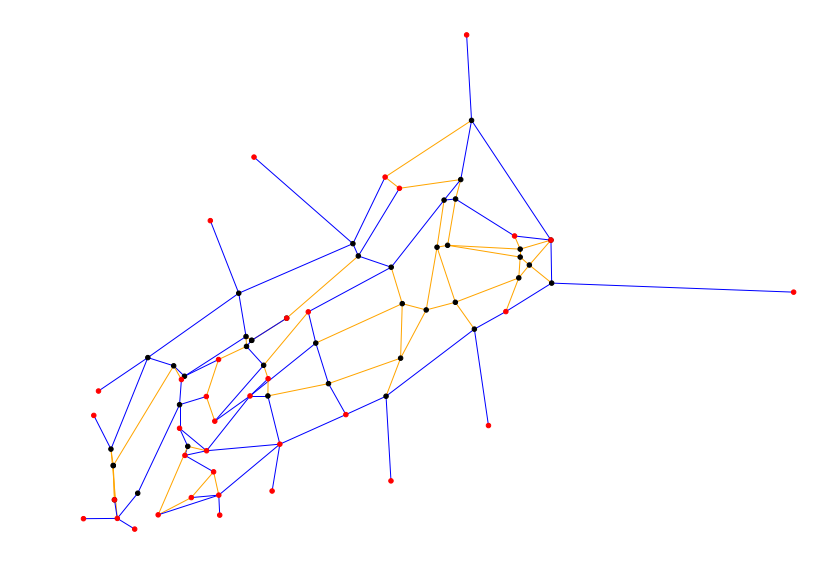

In [52]:
plt.figure(figsize=(14, 10))

visit_colors = {1:'orange', 2:'blue',3:'blue',4:'blue',5:'blue',6:'blue'}
edge_colors = [visit_colors[e[2]['visits']] for e in g_cpp.edges(data=True)]
node_colors = ['red'  if node in nodes_odd_degree else 'black' for node in g_cpp.nodes()]

nx.draw_networkx(g_cpp, pos=node_positions, node_size=20, node_color=node_colors, edge_color=edge_colors, with_labels=False)
plt.axis('off')
plt.show()

###### Visualization 2: CPP Solution Sequence

Here we plot the original graph (trail map) annotated with the sequence numbers in which we walk the trails per the CPP solution. Multiple numbers indicate trails we must double back on.

You start on the blue trail in the bottom right (0th and the 157th direction).



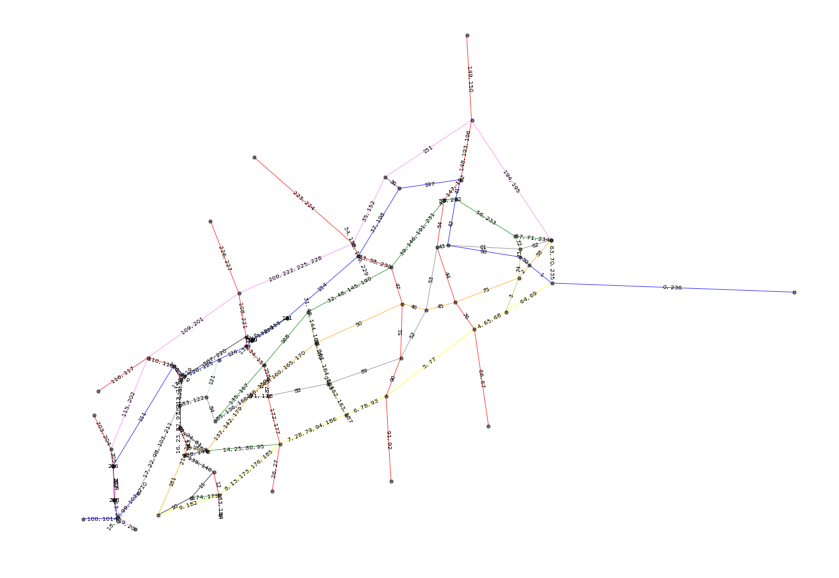

In [51]:
plt.figure(figsize=(14, 10))

edge_colors = [e[2]['attr_dict']['color'] for e in g_cpp.edges(data=True)]
nx.draw_networkx(g_cpp, pos=node_positions, node_size=10, node_color='black', edge_color=edge_colors, with_labels=False, alpha=0.5)

bbox = {'ec':[1,1,1,0], 'fc':[1,1,1,0]}  # hack to label edges over line (rather than breaking up line)
edge_labels = nx.get_edge_attributes(g_cpp, 'sequence')
nx.draw_networkx_edge_labels(g_cpp, pos=node_positions, edge_labels=edge_labels, bbox=bbox, font_size=6)

plt.axis('off')
plt.show()